In [24]:
# %load /home/taranarmo/Develop/Python3/python-jupyter_code_chunks/imports.py
import numpy as np
import pandas as pd
idx = pd.IndexSlice
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import re
import fnmatch
import datetime
from sympy import roots
import sys


In [2]:
# %load /home/taranarmo/Develop/Python3/python-jupyter_code_chunks/includeExterntalImportsDirectory.py
sys.path.append('/home/taranarmo/Develop/Python3/python-jupyter_code_chunks/')



In [3]:
from getClosest import get_closest

In [4]:
def guess_filename(working_dir=None):
    if not working_dir:
        working_dir = '.'
    hdr_file = fnmatch.filter(names=os.listdir(working_dir), pat="*.hdr")
    hdr_file = hdr_file[0]
    filename = hdr_file.split('.')[0]
    return filename


In [5]:
from adcp_filtering import filter_adcp_data

In [65]:
from fancy_date_axes import make_fancy_date_axis

### Read data

In [6]:
directories = {
    '⟂':"/home/taranarmo/Documents/NWPI/data/2019kilpis/aquadopp/Aquadopp_perpend_to_ice/",
    '∥':"/home/taranarmo/Documents/NWPI/data/2019kilpis/aquadopp/Aquadopp_parallelto_to_ice/",
}

In [7]:
def read_nortek_data_file(directory, amplitude=True):
    filename = guess_filename(directory)
    datatype = 'a' if amplitude else 'c'
    data = [pd.read_csv(
        f"{directory}{filename}.{datatype}{comp}",
        delim_whitespace=True,
        header=None,
        index_col=[0,1],
    ) for comp in [1,2,3]]
    return pd.concat(data, axis=1)

def make_filter_array(directory, amplitudeThreshold, correlationThreshold):
    return (
        (read_nortek_data_file(directory, True) < amplitudeThreshold) &
        (read_nortek_data_file(directory, False) < correlationThreshold)
    ).values

In [8]:
def read_and_prepare_data(directory, amplitudeThreshold=40, correlationThreshold=60):
    data = pd.read_hdf(f"{directory}{guess_filename(directory)}_beam.hdf5")
    data.mask(make_filter_array(directory, amplitudeThreshold, correlationThreshold), inplace=True)
    data = filter_adcp_data(data)
    data = data.resample('T', level=0).mean()
    data = data.loc[:"2019-05-16", :]
    return data

In [46]:
adcp_data = {key:read_and_prepare_data(
    directories[key],
    amplitudeThreshold=70,
    correlationThreshold=90,
) for key in directories.keys()}

### Calculating Reynolds stress

In [47]:
import json
import re

def get_T(directory):
    filename = guess_filename(directory)
    with open(f"{directory}{filename}.hdr") as f:
        hdr = f.read()
    T = re.search(r"Transforma.+$\n.+\n.+", hdr, re.M).group(0).split()[2:]
    T = np.matrix(np.reshape(np.float64(T), [3, 3]))
    if "DOWNLOOKING" in hdr:
        T[1:2, :] = T[1:2, :] * -1
    return T

def get_result_matrix(hh, pp, rr, T):
    H = np.matrix([
        [np.cos(hh), np.sin(hh), 0],
        [-np.sin(hh), np.cos(hh), 0],
        [0, 0, 1],
        ])
    P = np.matrix([
        [np.cos(pp), -np.sin(pp)*np.sin(rr), -np.cos(rr)*np.sin(pp)],
        [0, np.cos(rr), -np.sin(rr)],
        [np.sin(pp), np.sin(rr)*np.cos(pp), np.cos(pp)*np.cos(rr)],
        ])
    return np.array(H*P*T)

In [48]:
def make_R(directory):
    with open(f"{directory}rotation.json") as f:
        rotation = json.load(f)
    R = get_result_matrix(rotation["Heading"]-np.pi/2,rotation["Pitch"],rotation["Roll"], get_T(directory))
    return R

In [49]:
def make_b2r(R):
    return np.column_stack((
        R[:,0]**2,
        2*R[:,0]*R[:,1],
        2*R[:,0]*R[:,2],
        R[:,1]**2,
        2*R[:,1]*R[:,2],
        R[:,2]**2,
    ))

$$
\begin{bmatrix} u^2_1 \\ u_1u_2 \\ u_1u_3 \\ u^2_2 \\ u_2u_3 \\ u^2_3 \end{bmatrix}
=
\begin{bmatrix}
b_{1 \parallel} \\ b_{2 \parallel} \\ b_{3 \parallel} \\ b_{1 \perp} \\ b_{2 \perp} \\ b_{3 \perp}
\end{bmatrix}
*
inv \begin{bmatrix} b2R \end{bmatrix}
$$

In [50]:
def get_reynolds_stress(cell=1, detrend="10T", ensemble="100T", adcp_data=adcp_data):
    keys = list(adcp_data.keys())
    b2r = np.vstack(
        (
            make_b2r(make_R(directories[keys[0]])),
            make_b2r(make_R(directories[keys[1]])),
        )
    )
    b2r = np.matrix(b2r)
    cells = adcp_data[keys[0]].columns.levels[1].values
    cell = get_closest(sequence=cells, number=cell)
    data = np.hstack(
        (
            adcp_data[keys[0]].loc[:, idx[:, cell]].values,
            adcp_data[keys[1]].loc[:, idx[:, cell]].values,
        )
    )
    data = pd.DataFrame(index=adcp_data[keys[0]].index, data=data)
    data = data - data.rolling(detrend).mean()
    data = data.rolling(ensemble).mean()
    data = np.matrix(data.T.values**2)
    reynolds_stress = b2r * data
    return reynolds_stress.T

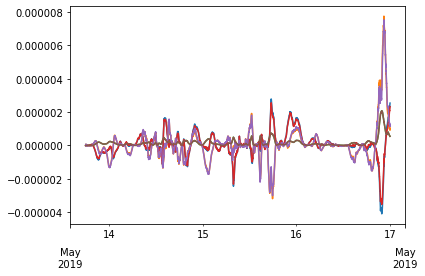

In [68]:
data = pd.DataFrame(
    get_reynolds_stress(.2, detrend="100T", ensemble="100T"),
    index = adcp_data['⟂'].index,
)
plt.plot(data)
make_fancy_date_axis()

In [60]:
sum(get_reynolds_stress(
    .2,
    detrend="100T",
    ensemble="100T")[:, 5])

matrix([[0.00079058]])